In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorcet as cc
import os
from datetime import datetime
import json
from PIL import Image

# 0. Define Input-Data

### 0.1 General Helpers

In [152]:
def print_df(df: pd.DataFrame):
    """printing data in table for easy readable in console output.

    Args:
        df (pd.DataFrame): any Dataframe for visualization
    """
    
    df.columns = df.columns.str.replace(' ', '')
    
    # Determine column width (including index)
    widths = [max(len("t"), 10)] + [max(len(str(x)), 20) for x in df.columns]

    # Center header (including “Index” as column index)
    header = " | ".join(str(col).center(width) for col, width in zip(["t"] + list(df.columns), widths))

    # Center values (including row index)
    rows = "\n".join(
    " | ".join(str(val).center(width) for val, width in zip([index] + list(row), widths))
    for index, row in zip(df.index, df.values)
    )

    # Merge and output
    print(header)
    print("-" * len(header))  # Dividing line
    print(rows)
    
    
def change_energy_units(
    values: list, 
    actual_unit: str, 
    target_unit: str):
    """Iterates through a list of values (int/float) and checks unit. If actual and target units differ it processes 
    all values into new unit and gives back new list as return value.

    Args:
        values (list): power or energy values
        actual_unit (str): actual unit of input values
        target_unit (str): target unit for values

    Returns:
        list: target values with intended target unit.
    """
    
    target_values = []
    
    # Permitted units
    kW_units = ['kW', 'kWh']
    MW_units = ['MW', 'MWh']
    GW_units = ['GW', 'GWh']
    
    for value in values: 
        if actual_unit in kW_units and target_unit in MW_units: 
            target_values.append(round((value / 1000),2))
        elif actual_unit in kW_units and target_unit in GW_units:
            target_values.append(round((value / 1000000),2))
        elif actual_unit in kW_units and target_unit in kW_units:
            target_values.append(round((value),2))
        elif actual_unit in MW_units and target_unit in GW_units:
            target_values.append(round((value / 1000),2))
        elif actual_unit in MW_units and target_unit in kW_units:
            target_values.append(round((value * 1000),2))
        elif actual_unit in MW_units and target_unit in MW_units:
            target_values.append(round((value),2))
        elif actual_unit in GW_units and target_unit in MW_units:
            target_values.append(round((value * 1000),2))
        elif actual_unit in GW_units and target_unit in kW_units:
            target_values.append(round((value * 1000000),2))
        elif actual_unit in GW_units and target_unit in GW_units:
            target_values.append(round((value),2))
        else: 
            raise KeyError("Unit not found. Check spelling or add unit in function.")
    
    # print(f"Calculation done for actual unit: {actual_unit} to target unit: {target_unit}")

    return target_values


def get_months_from_timestamp(
    timestamps: list
    ):
    """Adjust the strings contained by default for the month, 
    by deleting the year and leaving only the month as a string.

    Args:
        timestamps (list): input timestamps in list ['YYYY-MM', ...]

    Returns:
        list: converted list with months as strings
    """
    months = []
    for timestamp in timestamps:
        year = timestamp[:4]
        months.append(timestamp.replace(f'{year}-', ''))
        
    return months


def get_weeks_from_timestamp(
    timestamps: list
    ):
    """generates weeks from input-dates by cutting string and find out KW. Result is a list of Strings. 
    Useful for plotting diagrams based on weeks and not months.

    Args:
        timestamps (list): list of timestamps in format: ['YYYY-MM-DD/YYYY-MM-DD', ...] if weeks are set as granularity.

    Returns:
        list: list with strings of weeknumber [01, 02, 03, ...] based on startdate (suitbale for x axis)
    """
    weeks = []
    for timestamp in timestamps:
        start_str = timestamp.split('/')[0]  # note only the start value before the '/'
        
        # Convert start date to datetime
        start_date = datetime.strptime(start_str, "%Y-%m-%d")
        
        # Retrieve calendar week
        start_week = start_date.isocalendar()[1]
        weeks.append(start_week)
        
    return weeks


def get_days_from_timestamp(
    timestamps: list
    ):
    """generates plottable days from input-dates by cutting string. Result is a list of Strings. 
    Useful for plotting diagrams based on days (x-axis).

    Args:
        timestamps (list): list of timestamps in format: ['YYYY-MM-DD', ...] if days are set as granularity.

    Return:
        list: list with strings of days [01, 02, 03, ...] based on startdate (suitbale for x axis)
    """
    for timestamp in timestamps:
        date = timestamp[5:] # characters from MM-DD
        days = [datetime.strptime(date, "%Y-%m-%d").strftime("%d-%m") for date in timestamps] # Change to DD-MM
        
    # print("Days from Timestamp: ", days)
        
    return days


def get_hours_from_timestamp(
    timestamps: list
    ):
    """generates hours from input-dates by cutting string. Result is a list of Strings. 
    Useful for plotting diagrams based on hours (x-axis).

    Args:
        timestamps (list): list of timestamps in format: ['YYYY-MM-DD HH:MM', ...] if hours are set as granularity.

    Returns:
        list: list with strings of hours. New day gets date additionally (suitbale for x axis).
    """

    hours = []  # Liste zur Speicherung der formatierten Timestamps

    for timestamp in timestamps:
        dt = datetime.strptime(timestamp, "%Y-%m-%d %H:%M")  # String zu datetime-Objekt konvertieren
        formatted_time = dt.strftime("%d-%m %H:%M")  # Immer "DD-MM HH:MM" verwenden
        hours.append(formatted_time)  # Speichern des formatierten Timestamps

    # print("Hours from Timestamp:" , hours)
    
    return hours

### 0.2 Helpers for Colormaps

In [153]:
def register_colormap(cmap_name: str):
    """load colormap from plt and register in plt if colormap from cc.

    Args:
        cmap_name (str): colormap name as string registered in plt or cc.

    Returns:
       LinearSegmentedColormap : loaded colormap from plt.
    """
    if cmap_name not in plt.colormaps():
        colormap = cc.cm[cmap_name]  # load colormap from colorcet
        plt.register_cmap( # only if not available register colormap
            name=cmap_name, 
            cmap=ListedColormap(colormap(np.linspace(0, 1, 256))) 
            )  
    else:
        colormap = plt.get_cmap(cmap_name) # if already registered in matplotlib load map from there.
    return colormap


def shift_colormap(
    cmap_name:str, 
    start=0.0, 
    end=1.0,
    amount_colors = 256
    ):
    """
    Checks whether the specified colormap is a cc and must be registered for plt or can be loaded directly. 
    Returns a new colormap that only contains a partial area of the original colormap. Default: 0 and 1.
    
    Args:
        cmap_name (str): Name of the original colormap.
        spectrum_left(float): starting point of colormap (0.0 = left, 1.0 = right). Defaults to 0.
        spectrum_right (float): end point of colormap (0.0 = left, 1.0 = right). Defaults to 1.
        amount_colors (int): Amounts of colors extracted from map. Defaults to 256.
    
    Returns:
        LinearSegmentedColormap: adjusted colormap.
    """
    colormap = register_colormap(cmap_name=cmap_name)
    return LinearSegmentedColormap.from_list(f"{cmap_name}_adjusted", colormap(np.linspace(start, end, amount_colors)))


def darken_colormap(
    cmap_name:str, 
    factor:float,
    spectrum_left = 0.0,
    spectrum_right = 1.0,
    amount_colors = 256
    ):
    """
    Darkens the color map by scaling the RGB values.
    
    Args:
        cmap (Colormap): original colormap.
        factor (float): Scaling factor (0.0 = dark, 1.0 = original colors).
        spectrum_left(float): starting point of colormap (0.0 = left, 1.0 = right). Defaults to 0.
        spectrum_right (float): end point of colormap (0.0 = left, 1.0 = right). Defaults to 1.
        amount_colors (int): Amounts of colors extracted from map. Defaults to 256.
    
    Returns:
        LinearSegmentedColormap: adjusted colormap.
    """

    colormap = register_colormap(cmap_name=cmap_name)
    colors = colormap(np.linspace(spectrum_left, spectrum_right, amount_colors))     # Create a list of colors
    darkened_colors = colors.copy()     # Create a copy of the colors
    darkened_colors[:, :3] *= factor    # Only scale RGB values, alpha remains the same
    return LinearSegmentedColormap.from_list(f"{cmap_name}_darkened", darkened_colors)


def get_color_for_key(
    asset_name: str, 
    cmap_name:str, 
    assigned_colors:dict,
    spectrum_left = 0.0,
    spectrum_right = 1.0,
    amount_colors = 256
    ):
    """Assign colors for assets and save in dictionary with assigned_colors.

    Args:
        asset_name (str): String of asset name.
        cmap_name (str): colormap from which assets get colors assigned to
        assigned_colors (dict): existing color dictionary (can also be empty at the beginning)
        spectrum_left(float): starting point of colormap (0.0 = left, 1.0 = right). Defaults to 0.
        spectrum_right (float): end point of colormap (0.0 = left, 1.0 = right). Defaults to 1.
        amount_colors (int): Amounts of colors extracted from map. Defaults to 256.

    Returns:
        tuple: color tuple for one asset with color values in rgba data (values between 0 and 1).
    """
    colormap = register_colormap(cmap_name=cmap_name)
    colors = colormap(np.linspace(spectrum_left, spectrum_right, amount_colors))
    next_color = len(assigned_colors) % len(colors)
    if 'storage' in asset_name or 'grid' in asset_name:
        if asset_name not in assigned_colors:
            assigned_colors[asset_name] = colors[next_color]
            print(f"neue farbe für storage/grid: {asset_name}:", colors[next_color])
        
        return tuple(assigned_colors[asset_name])
        
    else: 
        asset_name_split = asset_name.split(".")[0]
        if asset_name_split not in assigned_colors:
            # If key does not have a color, give it the next one:            
            assigned_colors[asset_name_split] = colors[next_color]
            print(f"Neue farbe für asset: {asset_name_split}:", colors[next_color])
            
        return tuple(assigned_colors[asset_name_split])


def load_color_data_from_json(
    colors_file: str, 
    output_path: str
    ):
    """
    Loads color values for assets from a JSON file. If the file does not exist
    or is invalid, an empty dictionary is returned.

    Args:
        colors_file (str): name of JSON-file.
        output_path (str): path of saving output file.

    Returns:
        Tuple[dict, str]: Dictionary with the color assignments and file path.
    """
    input_file = os.path.join(output_path, colors_file)
    
    if os.path.exists(input_file):
        try:
            with open(input_file, "r") as file:
                assigned_colors = json.load(file)
            
            # Convert lists back into tuples
            assigned_colors = {
                key: tuple(value) for key, value in assigned_colors.items()
                }
        except (json.JSONDecodeError, ValueError):  # Intercept errors during loading
            print(f"Warnung: {input_file} ist beschädigt oder ungültig. Erstelle ein leeres Dictionary.")
            assigned_colors = {}
    else:
        print(f"Datei {input_file} existiert nicht. Erstelle ein neues Dictionary.")
        assigned_colors = {}

    return assigned_colors, input_file
    

def save_colors_for_key_json(
    colors_file: str, 
    assigned_colors: dict
    ):
    """
    Saves the dictionary with the color assignments in a JSON file.

    Args:
        colors_file (str): path of JSON-file.
        assigned_colors (dict): Dictionary with color assignments.
    """
    # convert NumPy-Arrays in lists
    serializable_colors = {
        key: value.tolist() if isinstance(value, np.ndarray) 
        else value for key, value in assigned_colors.items()
        }
    
    # save JSON file
    with open(colors_file, "w") as file:
        json.dump(serializable_colors, file, indent=4)
        
    print(f"JSON file saved as: {colors_file}")


def show_color_rgba(
    rgba_values:tuple
    ):
    """Show a color in form of rgba with values between 0 and 1.

    Args:
        rgba_values (tuple): 4 values of rgba between 0 and 1.
    """
    rgba_color_255 = tuple(int(color * 255) for color in rgba_values)
    image = Image.new("RGBA", (100, 100), rgba_color_255)
    image.show()


### 0.3 Load data from CSV Output:

In [154]:
def load_csv_results_in_df(
    input_path: str
    ):
    """Load output csv in dataframe.

    Args:
        input_path (str): path from which csv is loaded. 

    Returns:
        pd.DataFrame: csv data in dataframe as table type.
    """
    
    input_values_df = pd.read_csv(
        input_path, 
        index_col=0
        )
    
    return input_values_df


# 1. Functions for data processing from csv

In [155]:
def add_timestamp_and_filter(
    input_df = pd.DataFrame, 
    start_date = str, 
    end_date = str, 
    time_column = 'date'
    ):
    """Insert Dates (YYYY-MM-DD) in DataFrame and filter after given start and end date.
    Assumption: 8784 values (366 days) beginning at 01.01.2025. If necessary needs to be 
    flexibilized.

    Args:
        df (pd.DataFrame, optional): Input Dataframe from results. Defaults to pd.DataFrame.
        start_date (str, optional): first date for filtering. Defaults to str.
        end_date (str, optional): end date for filtering. It's always inkluded in time. Defaults to str.
        time_column (str, optional): name of column with time steps. Default value 'date'.

    Returns:
        pd.DataFrame: added colomn with dates and filtered Dataframe after time span.
    """
    # Create List of dates and hours belonging to timestep:
    dates = list(pd.date_range('2025-01-01', periods=8784, freq='H')) 
    input_df.insert(0, time_column, dates, allow_duplicates=False)
    input_df[time_column] = pd.to_datetime(input_df[time_column])
    # print_df(input_df)
    # Delete blank spaces of colomn names:
    input_df.columns = input_df.columns.str.replace(' ', '')
    # print("Inserted date columns: /n", print_df(input_df)) # show assigned dates and hours
    # Ensure that end_date covers the entire last day:
    end_date = pd.Timestamp(end_date) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    # Filter the DataFrame based on the corrected time range:
    return input_df[
        (input_df[time_column] >= pd.Timestamp(start_date)) & 
        (input_df[time_column] <= end_date)
    ]
    
# INPUT_PATH = "../data/output/gee23_ST-min_NW-ref_2028_output_cleaned.csv"
# df = load_csv_results_in_df(input_path=INPUT_PATH)
# START_DATE = "2025-06-01"
# END_DATE = "2025-06-10"
# filtered_df = add_timestamp_and_filter(df, START_DATE, END_DATE)
# # print_df(filtered_df)

def sums_by_granularity(
    input_df: pd.DataFrame, 
    granularity: str, 
    time_column = 'date',
    period_column = 'period'
    ):
    """group lines of dataframe to given granularity (years, months etc.) and 
    sum up values of columns beginning from second column.

    Args:
        input_df (pd.DataFrame, optional): Dataframe with existing time_column. Defaults to pd.DataFrame.
        granularity (str, optional): time granularity: hours, days, weeks, month, years. Defaults to str.
        time_column (str, optional): Name of column with time data. Default value 'date'.
        period_column (str, optional): Name of column with set period (month, weeks ...). Default value 'period'.

    Raises:
        ValueError: if another granularity is given than defined no groups can 
        be formed.

    Returns:
        pd.DataFrame: filtered DataFrame with relevant time span and granularity. Sums are calculated for time spans. 
    """
    
    df = input_df.copy()
    df[time_column] = pd.to_datetime(df[time_column])
    if granularity == 'month':
        df[period_column] = df[time_column].dt.to_period('M')
    elif granularity == 'year':
        df[period_column] = df[time_column].dt.to_period('Y')
    elif granularity == 'week':
        df[period_column] = df[time_column].dt.to_period('W')
    elif granularity == 'day':
        df[period_column] = df[time_column].dt.to_period('D')
    elif granularity == 'hour':
        df[period_column] = df[time_column].dt.to_period('H')
    else:
        raise ValueError("Invalid time granularity.")
    
    # calculate the totals from the 2nd column, index period is reset and round to 2 digits.
    time_sums_df = df.groupby(period_column).sum().reset_index().round(2) 
    time_sums_df[period_column] = time_sums_df[period_column].astype(str)  # convert periods to string format
    
    # Debug print: 
    # print_df(time_sums_df)
    
    return time_sums_df


def calculate_sums_for_period(
    input_df: pd.DataFrame, 
    start_date: str, 
    end_date: str, 
    granularity: str, 
    time_column='date',
    period_column='period'
    ):
    """Wrapper function: add and filter time values and sum up all values for time span and set granularity.

    Args:
        input_df (pd.DataFrame): Input Dataframe with all data from csv "output_time_series.csv"
        start_date (str): Start date for visualization. Format: 'YYYY-MM-DD'
        end_date (str): end date for visualization. Format: 'YYYY-MM-DD'
        granularity (str): granularity of time: "hours", "days", "weeks", "months", "years".
        time_column (str, optional): name of column with time data. Defaults to 'date'.
        period_column (str, optional): name of column with set period. Defaults to 'period'.

    Returns:
        pd.DataFrame: filtered dataframe after time and granularity and summed up data. 
    """
    time_filtered_df = add_timestamp_and_filter(
        input_df=input_df, 
        start_date=start_date, 
        end_date=end_date, 
        time_column=time_column
        )
    
    return sums_by_granularity(
        input_df=time_filtered_df, 
        granularity=granularity, 
        time_column=time_column, 
        period_column=period_column
        )

# 2. Functions for plot preparation (y values and x values)

In [156]:
def extract_assets_to_dict(
    time_series_df: pd.DataFrame, 
    assets: tuple, 
    type_of_energy: str
    ):
    """
    Reads certain columns associated with all relevant assets for the diagram from a DataFrame 
    and saves them in a dictionary.

    Parameters:
        time_series_df (pd.DataFrame): DataFrame, with all asset data summed up for certain granularity and time span.
        assets (tuple): A tuple with all assets that are to be displayed.
        type_of_energy (str): The type of energy that is relevant and can be read out with the assets.

    Returns:
        dict: A dictionary with the column names of the assets and the energy type according to the format 
        '{asset}.{type_of_energy}' as keys and the column values as an associated list.
    """
    # Generate the complete column names
    column_names = [f"{asset}.{type_of_energy}" for asset in assets]

    # Filter the desired columns:
    extracted_columns_dict = {
        col: list(time_series_df[col]) for col in column_names 
        if col in time_series_df.columns
        }
    
    return extracted_columns_dict


def calculate_asset_share_of_supply(
    asset_dict: dict,
    selected_assets: tuple,
    type_of_energy: str
    ):
    """Calculates the share of selected assets in the total supply of all specified assets. 

    Args:
        asset_dict (dict): all asset keys and their supply.
        selected_assets (tpl): selected assets for showing their share of total supply.
        type_of_energy: (str): type of energy (heat, power etc.)
        
    Returns:
        dict: New dict. The keys for the total demand per period have been added: 
        total_supply.{type_of_energy}, corresponding shares of selected assets with key 'share_of_assets' in percent and 
        selected_assets_supply.{type_of_energy} in actual unit.
        
    """
    supply_share_dict = {}
    # set keys: 
    share_key = "share_of_assets"
    total_supply_key = f"total_supply.{type_of_energy}"
    selected_supply_key = f"selected_assets_supply.{type_of_energy}"
    
    # Sum the values of the individual lists one after the other
    total_values = [sum(values) for values in zip(*asset_dict.values())]
    supply_share_dict[total_supply_key] = total_values
    # Check whether the selected assets (keys) are contained in the dict, 
    # add up their values and save them in the Dict.
    selected_values = [0] * len(total_values)

    # if assetname is in key sum up supply values and save in list.
    for key in asset_dict.keys():
        for asset in selected_assets:
            if asset in key:
                selected_values = [sum(values) for values in zip(selected_values, asset_dict[key])]
    
    # save supply for selected assets
    supply_share_dict[selected_supply_key] = selected_values
    
    # Determine the share of the supply of assets in the total value in percent. 
    share_values = [round((selected / total * 100),1) if total != 0 else 0 
                        for selected, total in zip(selected_values, total_values)]
    
    # save share of selected assets on total supply in dict.
    supply_share_dict[share_key] = share_values
    
    # Calculate total share of complete time span: 
    total_supply_sum = sum(supply_share_dict[total_supply_key])
    selected_assets_supply_sum = sum(supply_share_dict[selected_supply_key])
    total_share_selected_assets = round(((selected_assets_supply_sum / total_supply_sum) * 100),2)
    
    print("[calculate_asset_share_of_supply] Shares of assets on supply: ", supply_share_dict)
    print(f"[calculate_asset_share_of_supply] Total share of assets: {total_share_selected_assets:.2f}%")
    
    return supply_share_dict


def get_periods_for_plot(
    time_series_df: pd.DataFrame,  
    granularity: str,
    period_column = 'period'
    ):
    """Add a key with set period and time data to dictionary in a plottable format.

    Args:
        time_series_df (pd.DataFrame): Input Dataframe with filtered values and groups.
        granularity (str): granularity of time: "hours", "days", "weeks", "months", "years".
        period_column (str, optional): name of column with set period. Defaults to 'period'.

    Raises:
        KeyError: period needs to be an column name of DataFrame.

    Returns:
        list: period data for visualization in plot.
    """
    if period_column in time_series_df:
            raw_periods = time_series_df[period_column].tolist()
    else: 
        raise KeyError("period not found in time_series_df.")
    
    # print("Raw periods: ", raw_periods)
    
    if granularity == 'month':
        periods = get_months_from_timestamp(timestamps=raw_periods)
    elif granularity == 'week':
        periods = get_weeks_from_timestamp(timestamps=raw_periods)
    elif granularity == 'day':
        periods = get_days_from_timestamp(timestamps=raw_periods)
    elif granularity == 'hour':
        periods = get_hours_from_timestamp(timestamps=raw_periods)
    else: periods = raw_periods
    
    return periods


def get_asset_data_for_plot(
    time_series_df: pd.DataFrame,
    all_assets: tuple,
    selected_assets: tuple, 
    type_of_energy: str, 
    granularity: str,
    actual_unit = 'MWh', 
    target_unit = 'GWh'
):
    """Wrapper function: Extract relevant asset data from input to asset_dict as y values for box plot. 
    Generate supply_dict with total supply, supply of selected assets and their share on total supply in percent. 
    Value is labeled in box plot diagram. Extract time periods as values for x axis.

    Args:
        time_series_df (pd.DataFrame): Loaded data from csv. Already filtered and summed up for given start and end date and set time granularity.
        all_assets (tuple): input tuple of all assets that will be considered in plot. 
        selected_assets (tuple): my selected assets for which share of supply is calculated f. e. RES or District Heating.
        type_of_energy (str): Power, heat, CO2 or other type of energy that will be plotted.
        granularity (str): granularity of time: "hours", "days", "weeks", "months", "years".
        actual_unit (str, optional): Unit of input data. Defaults to 'MWh'.
        target_unit (str, optional): Target unit of plotted data. Defaults to 'GWh'.

    Returns:
        asset_dict: Dictionary with relevant asset data like keys and supply in target unit. 
        supply_shares_dict: supplies in actual unit and share in percent of selected assets.
        periods: list of time periods für x axis in box plot.
    """ 
    
    # get keys for all assets and get their supply. Save in dict.
    asset_dict = extract_assets_to_dict(
        time_series_df=time_series_df,
        assets=all_assets,
        type_of_energy=type_of_energy
        )
    print(f"Dict in actual unit {actual_unit}:  ", asset_dict)
    
    # Debug Code:
    # print("Asset Keys: ", asset_dict.keys())
    # print("Supply Shares Dict: ", supply_shares_dict)
    
    # Calculated supply from actual unit in target unit and overwrite values: 
    for key in asset_dict.keys():
        asset_dict[key] = change_energy_units(
            values=asset_dict[key], 
            actual_unit=actual_unit, 
            target_unit=target_unit
            )
    print(f"[get_asset_data_for_plot] Dict in target unit {target_unit}: ", asset_dict) 
    
    return asset_dict, calculate_asset_share_of_supply(asset_dict=asset_dict, selected_assets=selected_assets,type_of_energy=type_of_energy), get_periods_for_plot(time_series_df=time_series_df, granularity=granularity)

def get_data_for_storage_plot(
    type_of_energy: str,
    type_of_heat_storage: str,
    time_series_df: pd.DataFrame,
    asset_dict: dict,
    actual_unit: str, 
    target_unit: str
    ):
    """gets discharging data for storage values (heat or power) from time_series_df with summed up values and filtered time span. These lists with
    data are added to asset data that make up the supply for charging storages.  

    Args:
        type_of_energy (str): Type of energy. Actual storages: "heat", "power".
        type_of_heat_storage (str): If heat is given, defines which type of grid is chosen. Either "local" or "district".
        time_series_df (pd.DataFrame): DataFrame from output csv that is filtered by time and granularity. 
        asset_dict (dict): all asset keys and their supply.
        actual_unit (str): actual unit of input values
        target_unit (str): target unit for values

    Raises:
        KeyError: Raise Error if the storage variable is not integrated in function. 

    Returns:
        dict: Dictionary with storage_keys for assets (negative values charge) and discharge (excess heat, demand of heat grid positive) and belonging energy sums for set granularity in a list. 
        It also contains difference between charge and discharge. Values in lists from dict are given in target unit.
    """
    
    # get asset keys for stacked charging values. 
    keys_assets = list(asset_dict.keys())
    
    # select variables from names in csv: either district / local heat or power. 
    if type_of_energy == 'heat':
        # local heat grid variable names: 
        if type_of_heat_storage == 'local': 
            column_names = [
                f'{type_of_heat_storage}_{type_of_energy}_storage.{type_of_energy}_discharging', 
                f'{type_of_heat_storage}_{type_of_energy}_storage.excess_heat_discharging'
                ] 
        # district heat grid variable names: 
        else: 
            column_names = [
                f'{type_of_energy}_storage.{type_of_energy}_discharging'
                ] 
    # variable names for power/battery storage: 
    elif type_of_energy == 'power':
        storagename = 'battery'
        column_names = [
            f'{storagename}_storage.{type_of_energy}_discharging'
            ]
    else: 
        raise KeyError("[get_data_for_storage_plot] Storage variable not found.")
    
    column_names = keys_assets + column_names
    # load charging and discharging storage data in dict: 
    data_from_columns_dict = {
        col: list(time_series_df[col]) for col in column_names 
        if col in time_series_df.columns
        }
    
    print("storage data from df: ", data_from_columns_dict)
    
    # charging values get negative value.
    storage_dict = {
        key: [-x for x in value] if "_discharging" not in key else value 
        for key, value in data_from_columns_dict.items()
        }
    
    print(f"storage dict values in {actual_unit}: ", storage_dict)
    # calculate difference of storage values for different grids: 
    list_lengths = {len(storage_values) for storage_values in storage_dict.values()}  # Set mit allen Längen
    if len(list_lengths) != 1:
        raise ValueError("[get_data_for_storage_plot] Charging and discharging lists have different lengths!")
    
    net_storage_values = [round(sum(values),2) for values in zip(*storage_dict.values())]
    print(f"balance charging, discharging & excess in {actual_unit}: ", net_storage_values)
    
    # Output dictionary in actual unit
    storage_dict['balance'] = net_storage_values
    
    # change energy units from dict to target unit: 
    for key in storage_dict.keys():
        storage_dict[key] = change_energy_units(
            values=storage_dict[key], 
            actual_unit=actual_unit, 
            target_unit=target_unit
            )
    print(f"Dict storage in {target_unit}: ", storage_dict)
 
    return storage_dict


def get_demand_for_plot(
    type_of_energy: str,
    type_of_heat_grid: str,
    time_series_df: pd.DataFrame,
    actual_unit: str, 
    target_unit: str,
    assets_with_power_demand = None,
    assets_for_district_heat = None
    ):
    """builds keys of variables for demand, extracts columns with keys and loads them from df time series into dictionary.

    Args:
        type_of_energy (str): Type of energy: "heat", "power".
        type_of_heat_grid (str): if 'local' local variables used. 
        time_series_df (pd.DataFrame): DataFrame from output csv that is filtered by time and granularity. 
        actual_unit (str): actual unit of input values
        target_unit (str): target unit for values
        assets_with_power_demand (tuple, optional): If power is looked at, power consumption of named assets is loaded. Defaults to None.
        assets_for_district_heat (tuple, optional): If district heat looked at, then add asset.heat value.

    Raises:
        KeyError: type of energy must be integrated.

    Returns:
        dict: Dictionary with heat, local heat or power demand with values as list and variables as keys.
    """
    # heat demand: 
    if type_of_energy == 'heat':
        # local heat demand for 'local': 
        if type_of_heat_grid == 'local': 
            column_names = [f'{type_of_heat_grid}_{type_of_energy}_demand',
                            f'{type_of_heat_grid}_{type_of_energy}_storage.heat_discharging',
                            f'{type_of_heat_grid}_{type_of_energy}_grid.district_heat_feedin'] # local_heat_demand
        else: 
            # any string else for type_of_heat_grid = district heat:
            column_names = [f'{type_of_energy}_demand',
                             'local_heat_grid.district_heat_feedin',
                              'heat_storage.heat_charging',
                              'heat_grid.excess_heat_feedin',
                              'heat_storage.heat_discharging'
                             ] # district heat / general
            if assets_for_district_heat:
                for asset in assets_for_district_heat:
                    column_names.append(f'{asset}.heat')
            print("[get_demand_for_plot] assets for district heat added: ", column_names)
    # power demand mostly from heat supplying assets.
    elif type_of_energy == 'power':
        column_names = [f'{asset}.{type_of_energy}' for asset in assets_with_power_demand] # heat supplyers with power demand like heatpumps. Don't use power supplyers for this plot!
    else: 
        raise KeyError("[get_demand_for_plot] Demand variable not found.")
    
    # load variable data from df in dict:
    data_from_columns_dict = {
        col: list(time_series_df[col]) for col in column_names 
        if col in time_series_df.columns
        }
    
    print(
        f"[get_demand_for_plot] All {type_of_energy} demands from df in {actual_unit}: ", 
        data_from_columns_dict
        )
    
    if type_of_heat_grid == 'local':
        # Summiere alle Werte der jeweiligen Keys
        total_demand = sum(data_from_columns_dict[f'{type_of_heat_grid}_{type_of_energy}_demand'])
        total_storage = sum(data_from_columns_dict[f'{type_of_heat_grid}_{type_of_energy}_storage.heat_discharging'])
        total_grid_feed_in = sum(data_from_columns_dict[f'{type_of_heat_grid}_{type_of_energy}_grid.district_heat_feedin'])
        # Berechne den Prozentsatz
        grid_feed_in_percentage = (total_grid_feed_in / total_demand) * 100
        # Ergebnis ausgeben
        print(f"[get_demand_for_plot] FW-Anteil der Zeitpanne: {grid_feed_in_percentage:.2f}%")
    
    # change energy units to target unit: 
    for key in data_from_columns_dict.keys():
        data_from_columns_dict[key] = change_energy_units(
            values=data_from_columns_dict[key], 
            actual_unit=actual_unit, 
            target_unit=target_unit
            )
    
    print(
        f"[get_demand_for_plot] All {type_of_energy} demands from df in {target_unit}: ", 
        data_from_columns_dict
        )
 
    return data_from_columns_dict

# 3. Functions for simple plotting of supply (stacked) and demand.

In [157]:
def plot_shares_of_supply(
    asset_dict: dict,
    supply_shares_dict: dict,
    assigned_colors_dict:dict,
    colormap:str,
    periods: list,
    granularity: str,
    type_of_energy: str,
    sharename: str,
    fontsize: int,
    title_size: int,
    target_unit: str,
    key_to_label = None,
    heat_name = None,
    scenario_title = None
    ):
    """Function for plotting supply of assets as stacked bars. Unit and time granularity is determined, 
    colors are loaded for assets, label is set for share of interested assets like district heating or RES. 
    Return a figure of plt for saving next step.

    Args:
        asset_dict (dict): all asset keys and their supply.
        supply_shares_dict (dict): total_supply, corresponding shares of selected 
        assets with key 'share_of_assets' in percent and selected_assets_supply in 
        actual unit.
        assigned_colors_dict (dict): Dictionary with the color assignments
        colormap (str): Name of colormap
        periods (list): periods set for x axis.
        granularity (str): granularity of time.
        type_of_energy (str): energy type (heat, power etc.)
        sharename (str): name of share to be plotted (RES, District Heating, Solar_thermal etc.)
        fontsize (int): size of font in diagram
        target_unit (str): energy unit (default: GWh),
        title_size (int): size of font from diagram title.
        key_to_label (str, optional): asset names for which share needs to be calculated. If value is None, no label is set on bar. Default to: None. 
        heat_name (str, optional): Changes title from heat to either district heating or local heating if special grid is looked at.Default to: None (just heat in title).
        scenario_title (str, optional): Part of title to show extra information like which scenario is looked at (f. e. 0 % H2).

    Returns:
        fig: Diagram figure from plt.
    """
    
    # width of plotted bar
    bar_width = 0.7
    # Positions of the time data of the x-axis
    x_pos = np.arange(len(periods))
    # darkmode:
    plt.style.use('dark_background')
    # Create plot for Box plot
    fig, ax = plt.subplots(
        figsize=(16, 9), 
        dpi=100,
        facecolor='black'
        )
    # fig.patch.set_alpha(0.0) # weg!
    # for adjusting strings for plot and color selection:
    cleaned_dict = {}
    for asset, values in asset_dict.items():
            new_key = asset  # Standardmäßig bleibt der Key gleich
            if ".heat" in asset:
                new_key = asset.replace(".heat", "")
            elif ".power" in asset:
                new_key = asset.replace(".power", "")
            cleaned_dict[new_key] = values
    # Initialization for the offset of the stacked bars
    offsets = np.zeros(len(periods))
    # if granularity == 'hour':
    #     stacked_data = []
    #     labels = []
    #     colors = []
    #     load colors for asset entry:
    #     for asset, values in cleaned_dict.items():
    #         color_asset = get_color_for_key(
    #             asset_name=asset, 
    #             assigned_colors=assigned_colors_dict, 
    #             cmap_name=colormap, 
    #             amount_colors=10
    #             )
    #         stacked_data.append(values)
    #         labels.append(asset)
    #         colors.append(color_asset)

    #     # Plot stacked line diagram:
    #     ax.stackplot(
    #         x_pos, 
    #         stacked_data, 
    #         labels=labels, 
    #         colors=colors, 
    #         alpha=0.8
    #         )
    # else:
    for asset, values in cleaned_dict.items():
    # Get the color for the current asset
        color_asset = get_color_for_key(
            asset_name=asset, 
            assigned_colors=assigned_colors_dict, 
            cmap_name=colormap,
            amount_colors=10
            )
        # Draw the bars for the current asset
        bars = ax.bar(
            x_pos,             # positions on x axis
            values,             # values for heigh of bar
            width=bar_width,   # width of bar
            label=asset,       # label of bar
            color=color_asset,     # color of asset
            bottom=offsets,    # Offset for stacked bars
            zorder=2
        )
        # Show values directly on boxplot:
        if asset == key_to_label:
            # Show values from 'share_of_assets'
            for j, bar in enumerate(bars):
                ax.text(
                    bar.get_x() + bar.get_width() / 2,  # x position (centered on bar)
                    bar.get_height() + offsets[j],      # y position (above bar)
                    f"{supply_shares_dict['share_of_assets'][j]:.2f}%",  # value of 'share_of_assets'
                    ha='center', va='bottom',  # center text
                    fontsize=fontsize
                    )
        # update offset for next level
        offsets += values

    # axis and labels
    ax.grid(
        True, 
        color='gray', 
        linestyle='--', 
        linewidth=0.5, 
        zorder=3
        ) 
    ax.set_xlabel(
        f"Time in {granularity}s", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    
    # Show hourly values in MW: 
    if granularity == 'hour': 
        capacity = target_unit[:2] # Entferne h in targetunit
        ax.set_ylabel(
            f"supply of {type_of_energy} in {capacity}", 
            fontsize=fontsize, 
            fontweight='bold'
            )
    else: 
        ax.set_ylabel(
            f"supply of {type_of_energy} in {target_unit}", 
            fontsize=fontsize, 
            fontweight='bold'
            )
    # set title for different amounts of assets (shifting legend height):
    if len(asset_dict) <= 4: 
        y_title = 1.08
        height_legend = 1.0
    elif 5 <= len(asset_dict) < 9: 
        y_title = 1.18
        height_legend = 1.1
    elif 9 <= len(asset_dict) < 13: 
        y_title = 1.28
        height_legend = 1.2
    elif 13 <= len(asset_dict) < 17: 
        y_title = 1.38
        height_legend = 1.3
    else: 
        raise("too many assets, y title not set. ")
    if type_of_energy == 'heat': 
        if heat_name is not None: 
            ax.set_title(
                f"{sharename} {heat_name} supply per {granularity} {scenario_title}", #f"Shares of {sharename} on {heat_name} supply per {granularity} {scenario_title}", 
                fontsize=title_size, 
                fontweight='bold', 
                y=y_title
                ) # local / district heating
        else: 
            ax.set_title(
                f"Shares of {sharename} on {type_of_energy} supply per {granularity} {scenario_title}", 
                fontsize=title_size,
                fontweight='bold', 
                y=y_title
                )
    # set labels on correct position, for hours shift labels to left.
    ax.set_xticks(x_pos)
    if granularity == 'hour' or 'day': 
        ax.set_xticklabels(periods, rotation=45, ha='right')
    else: 
        ax.set_xticklabels(periods, rotation=45) 
    ax.tick_params(
        axis='x', 
        labelsize=fontsize
        ) 
    ax.tick_params(
        axis='y', 
        labelsize=fontsize
        )
    ax.legend(
        loc="lower center",           # position of legend
        bbox_to_anchor=(0.5, height_legend, 0, 0),   # anchor point (x=0.5 for central, y=1.0 for above)
        ncol=4,                      # amount of columns in legend
        frameon=True,                # Frame around legend
        fontsize=fontsize,
        title_fontsize=fontsize
        )
    # show diagram
    # plt.show() # just activate if save_plot function is deactivated
    plt.tight_layout()
    return fig


def plot_demands(
    periods: list,
    demand_dict: dict,
    assigned_colors_dict:dict,
    colormap:str,
    granularity: str,
    type_of_energy: str,
    fontsize: int,
    title_size: int,
    target_unit: str,
    assets_with_power_demand = None,
    type_of_heat_grid = None, 
    heat_name = None, 
    scenario_title = None
    ):
    """function for visualizing demands divided into heat, local heat and power grid. Visualizes demand in hourly values as stacked plot or with 
    higher granularity like days, months etc. in stacked bars. Uses colors of set color dictionary. 

    Args:
        periods (list): list if time strings converted as wished granularity is set. 
        demand_dict (dict): keys and values for set demand.
        assigned_colors_dict (dict): dictionary with color values in tuples (rgba) for assets and variables that wished to be visualized.
        colormap (str): belonging colormap for generating new color if asset not included yet in color dictionary.
        granularity (str): time span of values and x axis ('hour', 'day', 'week',..)
        type_of_energy (str): energy type that is looked as like heat or power.
        fontsize (int): size of fonts in plot.
        title_size (int): size of fonts in title of plot.
        target_unit (str): target unit of values and labels shown in plot.
        assets_with_power_demand (tuple, optional): Heat supplyers with power demand in tuple. Defaults to None.
        type_of_heat_grid (str, optional): if 'local' local variables are looked at. Defaults to None.
        heat_name (_type_, optional): Specification of heat title in diagram like 'local'. Defaults to None.
        scenario_title (str, optional): Part of title to show extra information like which scenario is looked at (f. e. 0 % H2).

    Returns:
        fig: bar or stacked plot figure for demand from plt.
    """
    # width of plotted bar
    bar_width = 0.7
    # Positions of the time data on the x-axis
    x_pos = np.arange(len(periods))
    # darkmode:
    plt.style.use('dark_background')
    
    # Single diagram for local heat or power: 
    if type_of_heat_grid == 'local' or type_of_energy == 'power':
        # Create plot for Box plot
        fig, ax = plt.subplots(
            figsize=(16, 9), 
            dpi=100, 
            facecolor="black"
            )
        # Initialization for the offset of the stacked bars
        offsets = np.zeros(len(periods))
        # different plot for hour in capacity and if power demand plotted different dict for getting colors!
        if granularity == 'hour':
            stacked_data = []
            labels = []
            colors = []
            # plot power demand from heat supplyers:
            if type_of_energy == 'power': 
                for index, (asset, values) in enumerate(demand_dict.items()):
                    # consider number of contained assets to avoid key error:
                    if index < len(assets_with_power_demand):
                        color_asset = get_color_for_key(
                            asset_name=assets_with_power_demand[index], 
                            assigned_colors=assigned_colors_dict, 
                            cmap_name=colormap, 
                            amount_colors=10
                            )
                        stacked_data.append(values)
                        labels.append(asset)
                        colors.append(color_asset)
                # Plot stacked chart for hourly values: 
                ax.stackplot(
                    x_pos, 
                    stacked_data, 
                    labels=labels, 
                    colors=colors, 
                    alpha=0.8
                    )
            else: 
                # plot heat demand in hourly values: 
                for asset, values in demand_dict.items():
                    if asset == 'local_heat_demand':
                        continue
                    else: 
                        color_asset = get_color_for_key(
                            asset_name=asset, 
                            assigned_colors=assigned_colors_dict, 
                            cmap_name=colormap, 
                            amount_colors=10
                            )
                        stacked_data.append(values)
                        labels.append(asset)
                        colors.append(color_asset)
                # Plot stacked chart for hourly values: 
                ax.stackplot(
                    x_pos, 
                    stacked_data, 
                    labels=labels, 
                    colors=colors,
                    alpha=0.8 # transparency, 1 non transparent, 0 invisible.
                    )
        else:
            # plot all other granularites in bar charts:
            for asset, values in demand_dict.items():
            # Get the color for the current asset
                if asset == 'local_heat_demand':
                    continue
                else: 
                    color_asset = get_color_for_key(
                    asset_name=asset, 
                    assigned_colors=assigned_colors_dict, 
                    cmap_name=colormap,
                    amount_colors=10
                    )
                # Draw the bars for the current asset
                    ax.bar(
                        x_pos,             # positions on x axis
                        values,             # values for heigh of bar
                        width=bar_width,   # width of bar
                        label=asset,       # label of bar
                        color=color_asset,     # color of asset
                        bottom=offsets,    # Offset for stacked bars
                        zorder=2
                    )
                
                    # update offset for next level
                    offsets += values
        # axis and labels
        ax.grid(
            True, 
            color='gray', 
            linestyle='--', 
            linewidth=0.5, 
            zorder=1
            ) 
        ax.set_xlabel(
            f"Time in {granularity}s", 
            fontsize=fontsize, 
            fontweight='bold'
            )
        # Show hourly values in MW:
        if type_of_energy == 'heat': 
            if granularity == 'hour':
                capacity = target_unit[:2] # delete h in targetunit string
                ax.set_ylabel(
                    f"demand of {type_of_heat_grid} {type_of_energy} in {capacity}", 
                    fontsize=fontsize, 
                    fontweight='bold'
                    )
            else:
                ax.set_ylabel(
                    f"demand of {type_of_heat_grid} {type_of_energy} in {target_unit}", 
                    fontsize=fontsize, 
                    fontweight='bold'
                    )
        else: 
            if granularity == 'hour':
                capacity = target_unit[:2] # delete h in targetunit string
                ax.set_ylabel(
                    f"demand of {type_of_energy} in {capacity}", 
                    fontsize=fontsize, 
                    fontweight='bold'
                    )
            else:
                ax.set_ylabel(
                    f"demand of {type_of_energy} in {target_unit}", 
                    fontsize=fontsize, 
                    fontweight='bold'
                    )
        # set title for different amounts of assets (shifting legend height):
        if len(demand_dict) <= 4: 
            y_title = 1.08
            height_legend = 1.0
        elif 5 <= len(demand_dict) < 9: 
            y_title = 1.18
            height_legend = 1.1
        else: 
            raise("too many demands, y title not set. ")
        # set title of plot: 
        if type_of_energy == 'heat':  
            if heat_name is not None: # local / district heating - adjustment for title possible. 
                ax.set_title(
                    f"Coverage of {heat_name} demand per {granularity} {scenario_title}", 
                    fontsize=title_size, 
                    fontweight='bold', 
                    y=y_title
                    ) 
            else: 
                ax.set_title(
                    f"{type_of_energy} demand per {granularity}", 
                    fontsize=title_size, 
                    fontweight='bold', 
                    y=y_title
                    )
        elif type_of_energy == 'power':
            ax.set_title(
                f"{type_of_energy} demand of {assets_with_power_demand[0]} per {granularity} {scenario_title}", 
                fontsize=title_size, 
                fontweight='bold', 
                y=y_title
                ) 
        # set labels on correct position, for hours shift labels to left.
        ax.set_xticks(x_pos)
        if granularity == 'hour' or 'day': 
            ax.set_xticklabels(
                periods, 
                rotation=45, 
                ha='right'
                )
        else: 
            ax.set_xticklabels(
                periods,
                rotation=45
                ) 
        ax.tick_params(
            axis='x', 
            labelsize=fontsize
            ) 
        ax.tick_params(
            axis='y', 
            labelsize=fontsize
            )
        ax.legend(
            loc="lower center",           # position of legend
            bbox_to_anchor=(0.5, height_legend, 0, 0),   # anchor point (x=0.5 for central, y=1.0 for above)
            ncol=4,                      # amount of columns in legend
            frameon=True,                # Frame around legend
            fontsize=fontsize,
            title_fontsize=fontsize
            )
        # show diagram
        # plt.show() # just activate if save_plot function is deactivated
        plt.tight_layout()
       
    # 2 diagrams for plotting district heat demand (above) and covering supply (below):      
    else: 
        # building 2 subplots: 
        fig, (ax_top, ax_bottom) = plt.subplots(
        2, 1, 
        sharex=True, 
        figsize=(16, 9), 
        gridspec_kw={'height_ratios': [1, 1]}
    )   
        offsets_top = np.zeros(len(periods))
        offsets_bottom = np.zeros(len(periods))
        
        for asset, values in demand_dict.items():
            # Get the color for the current asset
            color_asset = get_color_for_key(
                asset_name=asset, 
                assigned_colors=assigned_colors_dict, 
                cmap_name=colormap,
                amount_colors=10
                )
            
            # plot bars on diagram above:
            # just for chosen variables belonging to district heat demand: 
            if asset == 'heat_demand' or asset == 'local_heat_grid.district_heat_feedin' or asset == 'heat_storage.heat_charging':
                ax_top.bar(
                    x_pos,             # positions on x axis
                    values,             # values for heigh of bar
                    width=bar_width,   # width of bar
                    label=asset,       # label of bar
                    color=color_asset,     # color of asset
                    bottom=offsets_top,    # Offset for stacked bars
                    zorder=2
                )
                offsets_top += values
            else: 
            # Draw the bars for diagram below:
            # all variables belonging to supply: 
                ax_bottom.bar(
                    x_pos,             # positions on x axis
                    values,             # values for heigh of bar
                    width=bar_width,   # width of bar
                    label=asset,       # label of bar
                    color=color_asset,     # color of asset
                    bottom=offsets_bottom,    # Offset for stacked bars
                    zorder=2
                )
                # update offset for next level
                offsets_bottom += values
        # set axes and labels: 
        ax_top.grid(
            True, 
            color='gray', 
            linestyle='--', 
            linewidth=0.5, 
            zorder=1
            )
        ax_bottom.grid(
            True, 
            color='gray', 
            linestyle='--', 
            linewidth=0.5, 
            zorder=1
            ) 
        ax_bottom.set_xlabel(
            f"Time in {granularity}s", 
            fontsize=fontsize - 2, 
            fontweight='bold'
            )
        ax_top.set_ylabel(
            f"{type_of_energy} demand in {target_unit}", 
            fontsize=fontsize - 2, # usual fontsize too big for 2 diagrams under each other
            fontweight='bold'
            )
        ax_bottom.set_ylabel(
            f"{type_of_energy} supply in {target_unit}", 
            fontsize=fontsize - 2, 
            fontweight='bold'
            )
        fig.suptitle(
            f"Coverage of {heat_name} demand per {granularity} {scenario_title}", 
            fontsize=title_size, 
            fontweight='bold',
            y=1)
        
        # loop for identical data that belong to both diagrams: 
        for ax in [ax_top, ax_bottom]:
            ax.set_xticks(x_pos)
            if granularity in ['hour','day']: 
                ax.set_xticklabels(
                    periods, 
                    rotation=45, 
                    ha='right'
                    )
            else: 
                ax.set_xticklabels(
                    periods,
                    rotation=45
                    ) 
            ax.tick_params(
                axis='x', 
                labelsize=fontsize
                ) 
            ax.tick_params(
                axis='y', 
                labelsize=fontsize
                )
            ax.legend(
                loc="lower center",           # position of legend
                bbox_to_anchor=(0.5, 1.02, 0, 0),   # anchor point (x=0.5 for central, y=1.0 for above)
                ncol=3,                      # amount of columns in legend
                frameon=True,                # Frame around legend
                fontsize=fontsize,
                title_fontsize=fontsize
                )
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # space for title of diagram above
    
    return fig    

# 4 Functions for plotting storage values (fusion or single output)

In [158]:
def plot_shares_and_storage(
    asset_dict: dict,
    supply_shares_dict: dict,
    storage_dict: dict,
    assigned_colors_dict:dict,
    colormap:str,
    periods: list,
    granularity: str,
    type_of_energy: str,
    sharename: str,
    fontsize: int,
    title_size: int,
    target_unit: str,
    key_to_label = None,
    heat_name = None
    ):
    """Function for plotting supply of assets and charging and discharging energy from storage as stacked bars. 
    Unit and time granularity is determined, colors are loaded for assets and storage value, 
    label is set for share of interested assets like district heating or RES. 
    Storage plot is set under share plot sharing x axis with period values. 
    Return a figure of plt for saving next step.

    Args:
        asset_dict (dict): all asset keys and their supply.
        supply_shares_dict (dict): total_supply, corresponding shares of selected 
        assets with key 'share_of_assets' in percent and selected_assets_supply in 
        actual unit.
        storage_dict (dict): Dictionary with all variables and values for storage plot.
        assigned_colors_dict (dict): Dictionary with the color assignments of assets and storages.
        colormap (str): Name of colormap
        periods (list): periods set for x axis.
        granularity (str): granularity of time.
        type_of_energy (str): energy type (heat, power etc.)
        sharename (str): name of share to be plotted (RES, District Heating, Solar_thermal etc.)
        fontsize (int): size of font in diagram
        target_unit (str): energy unit (default: GWh),
        title_size (int): size of font from diagram title.
        key_to_label (str, optional): asset names for which share needs to be calculated. If value is None, no label is set on bar. Default to: None. 
        heat_name (str, optional): Changes title from heat to either district heating or local heating if special grid is looked at.Default to: None (just heat in title).

    Returns:
        fig: Diagram figure from plt with stagged bars. Above supply, below storage. Shares are always shown with color of assets.
    """
    # Width of plotted bars
    bar_width = 0.5
    # Positions of the time data on the x-axis
    x_pos = np.arange(len(periods))
    # darkmode:
    plt.style.use('dark_background')
    # Two subplots for stacked bar of assets and storage
    fig, axes = plt.subplots(
        nrows=2, 
        sharex=False, 
        figsize=(16, 9), 
        dpi=100,
        gridspec_kw={'height_ratios': [2, 1]} # above height doubled, (figsize (w, h))
        )  
    # first diagram above: Share of assets on supply:
    ax1 = axes[0]  # axis above
    offsets = np.zeros(len(periods))  # Stacking-Offsets
    # set colors and bars for assets and their values:
    for asset, values in asset_dict.items():
        color_asset = get_color_for_key(
            asset_name=asset, 
            assigned_colors=assigned_colors_dict, 
            cmap_name=colormap, 
            amount_colors=10
            )
        bars = ax1.bar(
            x_pos, 
            values, 
            width=bar_width, 
            label=asset, 
            color=color_asset, 
            bottom=offsets, 
            zorder=2
        )
        # set label with share of my assets on supply:
        if asset == key_to_label:
            for index, bar in enumerate(bars):
                ax1.text(
                    bar.get_x() + bar.get_width() / 2,  
                    bar.get_height() + offsets[index],  
                    f"{supply_shares_dict['share_of_assets'][index]:.2f}%",  
                    ha='center', 
                    va='bottom', 
                    fontsize=fontsize
                )
        offsets += values  # Update Offset for next level
    # Axis and labels for diagram above: 
    ax1.grid(
        True, 
        color='gray', 
        linestyle='--', 
        linewidth=0.5, 
        zorder=1
        )
    ax1.set_ylabel(
        f"Supply of {type_of_energy} in {target_unit}", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    # set title for different amounts of assets (shifting legend height):
    if len(asset_dict) <= 4: 
        y_title = 1.15
        height_legend = 1.15
    elif 5 <= len(asset_dict) < 9: 
        y_title = 1.25
        height_legend = 1.25
    elif 9 <= len(asset_dict) < 13: 
        y_title = 1.35
        height_legend = 1.35
    elif 13 <= len(asset_dict) < 17: 
        y_title = 1.45
        height_legend = 1.45
    else:
        raise ValueError("too many assets, y title not set. ")
    # Set titles, xticks, legend etc:
    if type_of_energy == 'heat': 
        if heat_name is not None: 
            ax1.set_title(
                f"Shares of {sharename} on {heat_name} supply per {granularity}", 
                fontsize=title_size, 
                fontweight='bold', 
                y=y_title
                ) # local / district heating            
    else: ax1.set_title(
        f"Shares of {sharename} on {type_of_energy} supply per {granularity}", 
        fontsize=title_size, 
        fontweight='bold', 
        y=y_title
        )
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([""] * len(periods)) # just label on ax2
    ax1.tick_params(
        axis='x', 
        labelsize=fontsize
        ) 
    ax1.tick_params(
        axis='y', 
        labelsize=fontsize
        )
    ax1.legend(
        loc="upper center", 
        bbox_to_anchor=(0.5, height_legend, 0, 0), 
        ncol=4,
        frameon=True, 
        fontsize=fontsize, 
        title_fontsize=fontsize
        )
    ### start of Second diagram ###
    # storage energy charging / discharging: 
    ax2 = axes[1]  # Axis for below 
    bottom_positive = np.zeros(len(periods))  # Stacking for positive bars 
    bottom_negative = np.zeros(len(periods))  # Stacking for negative bars
    # set colors for charging and discharging of storage: 
    storage_colors = {}
    for storage in storage_dict.keys():
            storage_colors[storage] = get_color_for_key(
                asset_name=storage, 
                assigned_colors=assigned_colors_dict, 
                cmap_name=colormap, 
                amount_colors=10
                )
    # draw values from storage_dict as bars: 
    for index, (item, values) in enumerate(storage_dict.items()):
        color_storage = storage_colors[item] 
        if "balance" not in item: # neu
        # categorize bars for positive or negative values: 
            for i, value in enumerate(values):
                if value >= 0:
                    ax2.bar(x_pos[i], value, width=bar_width, label=item if i == 0 else "",
                            color=color_storage, bottom=bottom_positive[i], zorder=2)
                    bottom_positive[i] += value  # Update positive stack 
                else:
                    ax2.bar(x_pos[i], value, width=bar_width, label=item if i == 0 else "",
                            color=color_storage, bottom=bottom_negative[i], zorder=2)
                    bottom_negative[i] += value  # Update negative stack 
    # Draw difference of storage energies in plot: 
    ax2.axhline(
        y=0, 
        color='white', 
        linewidth=0.7, 
        linestyle='-'
        )
    ax2.scatter(
        x_pos, 
        list(storage_dict.values())[-1], 
        color=list(storage_colors.values())[-1], 
        marker='x', 
        s=100, 
        label=list(storage_dict.keys())[-1], 
        linewidths=1.5, 
        zorder=3
        ) 
    plt.plot(
        x_pos, 
        list(storage_dict.values())[-1], 
        color=list(storage_colors.values())[-1], 
        linestyle='-', 
        linewidth=1.5
        )
    # Set legend handels for correct sorting of labels:
    handles, labels = ax2.get_legend_handles_labels()
    # put scatter handle at the end. Use shortened Keys for storage plot:
    new_labels = []
    for key in labels: 
        if '_discharging' in key: 
            new_labels.append(key.split(".")[-1]) # cut storage variable string at '.' and use back part of string 
        else: 
            new_labels.append(key.split(".")[0]) # cut asset variable at '.' and use part before for label
    # sort labels in legend new so 'difference' is last variable in legend.
    scatter_handle = handles.pop(labels.index(list(storage_dict.keys())[-1]))
    scatter_label = new_labels.pop(labels.index(list(storage_dict.keys())[-1]))
    handles.append(scatter_handle)
    new_labels.append(scatter_label) # vorher scatter lable
    # set legend: 
    ax2.legend(
        handles, 
        new_labels, 
        loc="upper center", 
        bbox_to_anchor=(0.5, 1.3, 0, 0), 
        ncol=6,
        frameon=True, 
        fontsize=fontsize, 
        title_fontsize=fontsize
        )
    # Labels of axis for storage values: 
    ax2.grid(
        True, 
        color='gray', 
        linestyle='--', 
        linewidth=0.5
        )
    ax2.set_ylabel(
        f"Stored {type_of_energy} in {target_unit}", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    ax2.set_xlabel(
        f"Time in {granularity}s", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(periods,rotation=45)
    ax2.tick_params(
        axis='x', 
        labelsize=fontsize
        ) 
    ax2.tick_params(
        axis='y', 
        labelsize=fontsize
        )
    plt.tight_layout()
    # plt.show() # activate if not saved later on. 
    return fig

def plot_storage(
    storage_dict: dict,
    assigned_colors_dict:dict,
    colormap:str,
    periods: list,
    granularity: str,
    type_of_energy: str,
    fontsize: int,
    title_size: int,
    target_unit: str,
    heat_name = None,
    scenario_title = None
    ):
    """same plot as above but standalone without showing asset supply above. Just represents storage. Charging values are supply values from 
    assets and are negative. positive values are supply by storage that runs into excess heat grid or local heat grid (demand).

    Args:
        storage_dict (dict): Dictionary with all variables and values for storage plot.
        assigned_colors_dict (dict): Dictionary with the color assignments of assets and storages.
        colormap (str): Name of colormap if new keys need to get a color.
        periods (list): time periods set for x axis.
        granularity (str): granularity of time (hour, day, week ...)
        type_of_energy (str): energy type (heat, power etc.)
        fontsize (int): size of font in diagram
        title_size (int): size of font from diagram title.
        target_unit (str): energy unit (default: GWh)
        heat_name (str, optional): Special title name for heat grid like local. Defaults to None.
        scenario_title (str, optional): Special title name at the end for information on scenario (like 0 % H2, UE24)

    Raises:
        ValueError: if too many assets title height is not defined and ValueError is given.

    Returns:
        fig: Diagram figure from plt with stagged bars as storage charging and discharging and balance.
    """
    
    # Width of plotted bars
    bar_width = 0.5
    # Positions of the time data on the x-axis
    x_pos = np.arange(len(periods))
    # darkmode:
    plt.style.use('dark_background')
    # Two subplots for stacked bar of assets and storage
    fig, ax = plt.subplots(
        figsize=(16, 9), 
        dpi=100, 
        facecolor="black"
        )    
    # storage energy charging / discharging: 
    bottom_positive = np.zeros(len(periods))  # Stacking for positive bars 
    bottom_negative = np.zeros(len(periods))  # Stacking for negative bars
    storage_colors = {}
    for storage in storage_dict.keys(): # hier in cleaned ändern
            storage_colors[storage] = get_color_for_key(
                asset_name=storage, 
                assigned_colors=assigned_colors_dict, 
                cmap_name=colormap, 
                amount_colors=10
                )
    print("[plot_storage] Storage colors: ", storage_colors)
    # stacked lines for hours than bars:
    if granularity == 'hour':
        stacked_data_positive = []
        stacked_data_negative = []
        labels = []
        colors = []
        for item, values in storage_dict.items():
            color_storage = storage_colors[item]
            if "balance" not in item:
                positive_values = [v if v >= 0 else 0 for v in values]
                negative_values = [v if v < 0 else 0 for v in values]
                stacked_data_positive.append(positive_values)
                stacked_data_negative.append(negative_values)
                labels.append(item)
                colors.append(color_storage)
        # Plot stacked lines diagram per hour:
        ax.stackplot(
            x_pos, 
            stacked_data_positive, 
            labels=labels, 
            colors=colors, 
            alpha=0.8, 
            zorder=2
            )
        ax.stackplot(
            x_pos, 
            stacked_data_negative, 
            colors=colors, 
            alpha=0.8, 
            zorder=2
            )
    # other granularity than hour.
    else:
        # set colors for charging and discharging of storage: 
        for storage in storage_dict.keys():
            storage_colors[storage] = get_color_for_key(
                asset_name=storage, 
                assigned_colors=assigned_colors_dict,
                cmap_name=colormap, 
                amount_colors=10
                )
        # draw values from storage_dict as bars: 
        for item, values in storage_dict.items():
            color_storage = storage_colors[item] 
            # print("item of storage: ", item)
            if "balance" not in item: # neu
            # categorize bars for positive or negative values: 
                # print("item after Bedingung: ", item)
                for i, value in enumerate(values):
                    if value >= 0:
                        ax.bar(
                            x_pos[i], 
                            value, 
                            width=bar_width, 
                            label=item if i == 0 else "",
                            color=color_storage, 
                            bottom=bottom_positive[i], 
                            zorder=2
                            )
                        bottom_positive[i] += value  # Update positive stack 
                    else:
                        ax.bar(
                            x_pos[i], 
                            value, 
                            width=bar_width, 
                            label=item if i == 0 else "",
                            color=color_storage, 
                            bottom=bottom_negative[i], 
                            zorder=2
                            )
                        bottom_negative[i] += value  # Update negative stack 
    # Draw difference of storage energies in plot: 
    ax.axhline(
        y=0, 
        color='white', 
        linewidth=0.7, 
        linestyle='-'
        )
    ax.scatter(
        x_pos, 
        list(storage_dict.values())[-1], 
        color=list(storage_colors.values())[-1], 
        marker='x', 
        s=100, 
        label=list(storage_dict.keys())[-1], 
        linewidths=1.5, 
        zorder=3
        ) 
    plt.plot(
        x_pos, 
        list(storage_dict.values())[-1], 
        color=list(storage_colors.values())[-1], 
        linestyle='-', 
        linewidth=1.5
        )
    # set title for different amounts of assets (shifting legend height):
    if len(storage_dict) <= 4: 
        y_title = 1.05
        height_legend = 1.05
    elif 5 <= len(storage_dict) < 9: 
        y_title = 1.1
        height_legend = 1.1
    elif 9 <= len(storage_dict) < 13: 
        y_title = 1.15
        height_legend = 1.15
    elif 13 <= len(storage_dict) < 17: 
        y_title = 1.2
        height_legend = 1.2
    else:
        raise ValueError("too many assets, y title not set. ")
    if type_of_energy == 'heat': 
        if heat_name is not None: 
            ax.set_title(
                f"{heat_name} storage charge and discharge per {granularity} {scenario_title}", # local / district heating     
                fontsize=title_size, 
                fontweight='bold', 
                y=y_title
                )        
    else:
        ax.set_title(
            f"Battery storage charge and discharge per {granularity} {scenario_title}", 
            fontsize=title_size, 
            fontweight='bold', 
            y=y_title
            )
    # Set legend handels for correct sorting of labels:
    handles, labels = ax.get_legend_handles_labels()
    # put scatter handle at the end. Use shortened Keys for storage plot:
    new_labels = []
    for key in labels: 
        if '_discharging' in key: 
            new_labels.append(key.split(".")[-1]) # Storage Variable an . abschneiden und hinteren teil für Label verwenden 
        else: 
            new_labels.append(key.split(".")[0]) # Asset vor .heat für Label extrahieren
    # print("labels neu: ", new_labels)
    scatter_handle = handles.pop(labels.index(list(storage_dict.keys())[-1]))
    scatter_label = new_labels.pop(labels.index(list(storage_dict.keys())[-1]))
    handles.append(scatter_handle)
    new_labels.append(scatter_label) # vorher scatter lable
    # set legend: 
    ax.legend(
        handles, 
        new_labels, 
        loc="upper center", 
        bbox_to_anchor=(0.5, height_legend, 0, 0), 
        ncol=len(storage_dict),
        frameon=True, 
        fontsize=fontsize, 
        title_fontsize=fontsize
        )
    # Labels of axis for storage values: 
    ax.grid(
        True, 
        color='gray', 
        linestyle='--', 
        linewidth=0.5
        )
    ax.set_ylabel(
        f"Stored {type_of_energy} in {target_unit}", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    if granularity == 'hour': 
        capacity = target_unit[:2] # Entferne h in targetunit
        ax.set_ylabel(
            f"storage {type_of_energy} supply in {capacity}", 
            fontsize=fontsize, 
            fontweight='bold'
            )
    else: 
        ax.set_ylabel(
            f"storage {type_of_energy} supply in {target_unit}", 
            fontsize=fontsize, 
            fontweight='bold'
            )
    ax.set_xlabel(
        f"Time in {granularity}s", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    ax.set_xticks(x_pos)
    ax.set_xticklabels(periods,rotation=45)
    ax.tick_params(
        axis='x', 
        labelsize=fontsize
        ) 
    ax.tick_params(
        axis='y', 
        labelsize=fontsize
        )
    plt.tight_layout()
    # plt.show() # activate if not saved later on. 
    return fig

# 5. Compare two data sets from csv in one plot

In [159]:
def compare_plots(
    asset_dict1: dict,
    asset_dict2: dict,
    assigned_colors_dict:dict,
    colormap:str,
    periods: list,
    granularity: str,
    type_of_energy: str,
    fontsize: int,
    title_size: int,
    target_unit: str,
    heat_name = None,
    scenario_title = None
    ):
    """Function that plots stacked supply of assets from 2 scenarios (csv). Left plot (input_path_1) is in colors from colors dict (json),
    right plot has same colors but slightly darker to distinguish scenarios and still get the assignment of assets to colors.

    Args:
        asset_dict1 (dict): asset data from first input path.
        asset_dict2 (dict): asset data from second input path.
        assigned_colors_dict (dict): dictionary with all colors in json file.
        colormap (str): colormap for new color if asset not in dict.
        periods (list): list of time data. 
        granularity (str): time granularity like hours, day, week ...
        type_of_energy (str): Type of energy that is plotted (heat, power).
        fontsize (int): size of fonts in diagram.
        title_size (int): size of fonts of title in diagram.
        target_unit (str): target unit of data in plot and label on y axis.
        heat_name (_type_, optional): special name for heat grid if 'local' used.. Defaults to None.
        scenario_title (str, optional): Special space for information in title like (0 % H2, UE24)

    Returns:
        fig: Diagram figure from plt with stagged bars from supply. Two bars next to each other for one x tick.
    """
    # width of plotted bar
    bar_width = 0.4
    # Positions of the time data on the x-axis
    x_pos = np.arange(len(periods))
    # darkmode:
    plt.style.use('dark_background')
    # Create plot for Box plot
    fig, ax = plt.subplots(
        figsize=(16, 9), 
        dpi=100, 
        facecolor="black"
        )
    # Initialization for the offset of the stacked bars
    # Bar on the left: 
    offsets_A = np.zeros(len(periods))
    # not for hour possible!
    for asset, values in asset_dict1.items():
    # Get the color for the current asset
        color_asset = get_color_for_key(
            asset_name=asset, 
            assigned_colors=assigned_colors_dict, 
            cmap_name=colormap,
            amount_colors=10
            )
        # Draw the bars for the current asset
        ax.bar(
            x_pos - bar_width/2,            # positions on x axis (left bar -, right bar +)
            values,             # values for heigh of bar
            width=bar_width,   # width of bar
            label=asset,       # label of bar
            color=color_asset, # color of asset
            bottom=offsets_A,    # Offset for stacked bars
            zorder=2
        )
        offsets_A += np.array(values)
    # Bar on the right: 
    offsets_B = np.zeros(len(periods))
    for asset, values in asset_dict2.items():
    # Get the color for the current asset
        color_asset = get_color_for_key(
            asset_name=asset, 
            assigned_colors=assigned_colors_dict, 
            cmap_name=colormap,
            amount_colors=10
            )
        # darker color: 
        dark_factor = 0.7  # Werte unter 1 machen die Farbe dunkler
        darker_color = ( # set darker_factor for each element in rgba structure except of alpha.
            color_asset[0] * dark_factor, 
            color_asset[1] * dark_factor, 
            color_asset[2] * dark_factor, 
            color_asset[3]
            )
        # Draw the bars for the current asset
        ax.bar(
            x_pos + bar_width/2,             # positions on x axis
            values,             # values for heigh of bar
            width=bar_width,   # width of bar
            label=asset,       # label of bar
            color=darker_color, # color of asset
            bottom=offsets_B,    # Offset for stacked bars
            zorder=2
        )
        offsets_B += np.array(values)
    # axis and labels
    ax.grid(
        True, 
        color='gray', 
        linestyle='--', 
        linewidth=0.5, 
        zorder=1
        ) 
    ax.set_xlabel(
        f"Time in {granularity}s", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    # Show hourly values in MW:
    ax.set_ylabel(
        f"supply of {type_of_energy} in {target_unit}", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    # set title for different amounts of assets (shifting legend height):
    if len(asset_dict1) <= 4: 
        y_title = 1.08
        height_legend = 1.0
    elif 5 <= len(asset_dict1) < 9: 
        y_title = 1.18
        height_legend = 1.1
    elif 9 <= len(asset_dict1) < 13: 
        y_title = 1.28
        height_legend = 1.2
    elif 13 <= len(asset_dict1) < 17: 
        y_title = 1.38
        height_legend = 1.3
    else: 
        raise("too many assets, y title not set. ")
    # set title of plot: 
    if type_of_energy == 'heat': 
        if heat_name is not None: # local / district heating
            ax.set_title(
                f"Comparison of {heat_name} supply per {granularity} {scenario_title}", 
                fontsize=title_size, 
                fontweight='bold', 
                y=y_title
                ) 
        else: 
            ax.set_title(
                f"Comparison of {type_of_energy} supply per {granularity} {scenario_title}", 
                fontsize=title_size, 
                fontweight='bold', 
                y=y_title
                )
    # set labels on correct position, for hours shift labels to left.
    ax.set_xticks(x_pos)
    if granularity == 'hour' or 'day': 
        ax.set_xticklabels(
            periods, 
            rotation=45, 
            ha='right'
            )
    else: 
        ax.set_xticklabels(
            periods, 
            rotation=45
            ) 
    ax.tick_params(
        axis='x', 
        labelsize=fontsize
        ) 
    ax.tick_params(
        axis='y', 
        labelsize=fontsize
        )
    handles, labels = ax.get_legend_handles_labels()
    # remove entries that are spelled the same:
    unique_labels = {}
    filtered_handles = []
    filtered_labels = []

    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels[label] = handle
            filtered_handles.append(handle)
            filtered_labels.append(label)
    ax.legend(
        filtered_handles,
        filtered_labels,
        loc="lower center",           # position of legend
        bbox_to_anchor=(0.5, height_legend, 0, 0),   # anchor point (x=0.5 for central, y=1.0 for above)
        ncol=4,                      # amount of columns in legend
        frameon=True,                # Frame around legend
        fontsize=fontsize,
        title_fontsize=fontsize
        )
    # show diagram
    # plt.show() # just activate if save_plot function is deactivated
    plt.tight_layout()
    return fig 

# 6. Plot specific value from csv.

In [160]:
def plot_specific_value(
    name_of_value: str,
    time_series_df: pd.DataFrame,
    assigned_colors_dict:dict,
    colormap:str,
    periods: list,
    granularity: str,
    fontsize: int,
    title_size: int,
    target_unit: str,
    scenario_title = None
    ):
    """ A simple function for plotting a value from csv as bar charts. For this name of value is necessary.
    The filtered time series df is a necessary input. 

    Args:
        name_of_value (str): Column name given in csv data
        time_series_df (pd.DataFrame): Dataframe with timefiltered data from csv.
        assigned_colors_dict (dict): dictionary with colors matching column names of csv.
        colormap (str): colormap for color allocation to column name.
        periods (list): x values with time in set granularity.
        granularity (str): time granularity (months, weeks etc.)
        fontsize (int): Size of fonts in diagram
        title_size (int): Size of title in diagram
        target_unit (str): wished y-unit appearance in diagram.
        scenario_title (str, optional): Extra information in title like (0 % H2, UE24) . Defaults to None.

    Raises:
        ValueError: Lengths of periods and loaded values from column need to be the same.

    Returns:
        fig: Matplotlib figure for saving.
    """
    
    # get value from df:
    value_dict = {}
    if name_of_value in time_series_df.columns:
        value_dict[name_of_value] = list(time_series_df[name_of_value])
    if len(value_dict[name_of_value]) != len (periods):
        raise ValueError(f"Länge von '{name_of_value}' ({len(value_dict[name_of_value])}) stimmt nicht mit Anzahl der Zeitstempel ({len(periods)}) überein.")
    print("[plot_specific_value] specific value data: ", value_dict)
    # plot data: 
    # width of plotted bar
    bar_width = 0.7
    # Positions of the time data on the x-axis
    x_pos = np.arange(len(periods))
    # darkmode:
    plt.style.use('dark_background')
    # Create plot for Box plot
    fig, ax = plt.subplots(
        figsize=(16, 9), 
        dpi=100, 
        facecolor="black"
        )
    # Initialization for the offset of the stacked bars 
    offsets = np.zeros(len(periods))
    for asset, values in value_dict.items():
    # Get the color for the current asset
        color_asset = get_color_for_key(
            asset_name=asset, 
            assigned_colors=assigned_colors_dict, 
            cmap_name=colormap,
            amount_colors=10
            )
        # Draw the bars for the current asset
        ax.bar(
            x_pos,           
            values,             # values for heigh of bar
            width=bar_width,   # width of bar
            label=asset,       # label of bar
            color=color_asset, # color of asset
            bottom=offsets,    # Offset for stacked bars
            zorder=2
        )
        offsets += np.array(values)
    # axis and labels
    ax.grid(
        True, 
        color='gray', 
        linestyle='--', 
        linewidth=0.5, 
        zorder=1
        ) 
    ax.set_xlabel(
        f"Time in {granularity}s", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    # Show hourly values in MW:
    ax.set_ylabel(
        f"{name_of_value} in {target_unit}", 
        fontsize=fontsize, 
        fontweight='bold'
        )
    # set title for different amounts of assets (shifting legend height):
    y_title = 1.08
    height_legend = 1.0
    # set title of plot: 
    ax.set_title(
        f"{name_of_value} per {granularity} {scenario_title}", 
        fontsize=title_size, 
        fontweight='bold', 
        y=y_title
        ) 
    # set labels on correct position, for hours shift labels to left.
    ax.set_xticks(x_pos)
    if granularity == 'hour' or 'day': 
        ax.set_xticklabels(
            periods, 
            rotation=45, 
            ha='right'
            )
    else: 
        ax.set_xticklabels(
            periods, 
            rotation=45
            ) 
    ax.tick_params(
        axis='x', 
        labelsize=fontsize
        ) 
    ax.tick_params(
        axis='y', 
        labelsize=fontsize
        )
    handles, labels = ax.get_legend_handles_labels()
    # remove entries that are spelled the same:
    unique_labels = {}
    filtered_handles = []
    filtered_labels = []

    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels[label] = handle
            filtered_handles.append(handle)
            filtered_labels.append(label)
    ax.legend(
        filtered_handles,
        filtered_labels,
        loc="lower center",           # position of legend
        bbox_to_anchor=(0.5, height_legend, 0, 0),   # anchor point (x=0.5 for central, y=1.0 for above)
        ncol=4,                      # amount of columns in legend
        frameon=True,                # Frame around legend
        fontsize=fontsize,
        title_fontsize=fontsize
        )
    # show diagram
    # plt.show() # just activate if save_plot function is deactivated
    plt.tight_layout()
    return fig 

# 7. Function for saving plots of any kind.

In [161]:
def save_plot(
    fig, 
    output_path: str, 
    filename: str, 
    dpi: int = 300, 
    format: str = "png"
    ):
    """Saves the given plot in a file.

    Args:
        fig (matplotlib.figure.Figure): The diagram to be saved.
        output_path (str): Path to folder for saving file.
        filename (str): The file name (incl. path) for the saved file.
        dpi (int): The resolution of the picture.
        format (str): Data formate (f. e. "png", "pdf", "svg").
    """
    
    output_file = os.path.join(
        output_path, 
        filename
        )
    plt.savefig(
        output_file, 
        format=format, 
        dpi=dpi, 
        facecolor="black", 
        transparent=True ##########################################
        )
    plt.show()
    plt.close(fig)
    print(f"Diagram saved as: {output_file}")

# 8. Wrapper for Main function: Decide for plot with input value

In [187]:
def decide_for_diagram_and_plot(
    storage_diagram: str, 
    heat_demand_diagram: bool,
    compare_supplies_diagram: bool,
    specific_value_diagram: bool,
    time_series_df1: pd.DataFrame,
    all_assets: tuple,
    selected_assets: tuple,
    type_of_energy: str,
    granularity: str,
    actual_unit: str,
    target_unit: str, 
    sharename: str,
    fontsize: int,
    title_size:int,
    colormap: str,
    assigned_colors_dict:dict,
    type_of_heat_grid = None,
    key_to_label = None,
    heat_name = None,
    assets_demand = None,
    time_series_df2 = None,
    scenario_title = None,
    specific_value = None
    ):
    """Wrapper function for Main script: Executes get asset data and plot functions. 
    Chooses if storage is included in plot or only share of assets.

    Args:
        storage_diagram (str): If 'fusion', storage is shown below share of assets diagram. If 'single' 
        only storage is plotted, else share of assets diagram is plotted.
        heat_demand_diagram (bool): set to True if demand is supposed to be plotted. 
        compare_supplies_diagram (bool): Set to True if two datasets are compared. Second time series df necessary.
        specific_value_diagram (bool): Set to True if specific value is wished to be shown.
        time_series_df1 (pd.DataFrame): DataFrame from output csv from input path 1 that is filtered by time and granularity.
        all_assets (tuple): A tuple with all assets that are to be displayed.
        selected_assets (tuple): my selected assets for which share of supply is calculated f. e. RES or District Heating.
        type_of_energy (str): Type of energy that is plotted (heat, power).
        granularity (str): time granularity for plot (hour, day, week,...)
        actual_unit (str): actual unit of input values
        target_unit (str): target unit of output values
        sharename (str): name of share to be plotted (RES, District Heating, Solar_thermal etc.)
        fontsize (int): Size of font in plot. 
        title_size (int): fontsize of diagram title in plot.
        key_to_label (str): asset names for which share needs to be calculated. If value is None, no label is set on bar. Default to: None.
        colormap (str): name of colormap from cc or plt.
        assigned_colors_dict (dict):  Dictionary with the color assignments of assets and storages.
        type_of_heat_grid (str, optional): None district heat, 'local' local heat grid variables used for plot.
        heat_name (str, optional): title for special heat grid. Defaults to None.
        assets_demand (tuple, optional): Tuple with asset names that have power demand (f. e. heatpumps). Defaults to None.
        time_series_df2 (pd.DataFrame, optional): second dataframe from input path 2. Necessary for compare plot. Defaults to None.
        scenario_title (str, optional): Extra field for title to add scenario like (0 % H2, UE24)
        specific_value (str, optional): If wished, string of specific value from output csv is needed.

    Raises:
        ValueError: No diagram is selected. Variables of input need to be checked. 

    Returns:
        fig: Plot figure for further processing or saving.
    """
    # Supply and storage below = 'fusion':
    if storage_diagram == 'fusion': 
        asset_plot_dict, supply_shares_dict, 
        periods = get_asset_data_for_plot(
        time_series_df=time_series_df1, 
        all_assets=all_assets,
        selected_assets=selected_assets,
        type_of_energy=type_of_energy,
        granularity=granularity,
        actual_unit=actual_unit,
        target_unit=target_unit
        )
        # print("asset_plot before storage: ", asset_plot_dict)
        storage_dict = get_data_for_storage_plot(
            type_of_energy=type_of_energy,
            type_of_heat_storage=type_of_heat_grid,
            time_series_df=time_series_df1,
            asset_dict=asset_plot_dict,
            actual_unit=actual_unit,
            target_unit=target_unit
            )
        
        fig = plot_shares_and_storage(
            asset_dict= asset_plot_dict, 
            supply_shares_dict = supply_shares_dict,
            storage_dict=storage_dict,
            granularity=granularity,
            type_of_energy=type_of_energy,
            sharename=sharename,
            fontsize=fontsize,
            title_size=title_size,
            key_to_label=key_to_label,
            periods = periods,
            target_unit = target_unit,
            colormap=colormap,
            assigned_colors_dict=assigned_colors_dict,
            heat_name = heat_name
            )
    # plot with storage charge, discharge and balanced in own graphic if "single":
    elif storage_diagram == 'single': 
        asset_plot_dict, supply_shares_dict, periods = get_asset_data_for_plot(
            time_series_df=time_series_df1, 
            all_assets=all_assets,
            selected_assets=selected_assets,
            type_of_energy=type_of_energy,
            granularity=granularity,
            actual_unit=actual_unit,
            target_unit=target_unit
        )
        # print("asset_plot before storage: ", asset_plot_dict)
        storage_dict = get_data_for_storage_plot(
            type_of_energy=type_of_energy,
            type_of_heat_storage=type_of_heat_grid,
            time_series_df=time_series_df1,
            asset_dict=asset_plot_dict,
            actual_unit=actual_unit,
            target_unit=target_unit
            )
        fig = plot_storage(
            storage_dict = storage_dict,
            assigned_colors_dict=assigned_colors_dict,
            colormap=colormap,
            periods=periods,
            granularity=granularity,
            type_of_energy=type_of_energy,
            fontsize=fontsize,
            title_size=title_size,
            target_unit=target_unit,
            heat_name = heat_name,
            scenario_title = scenario_title
            )
    # plot of demand: 
    elif heat_demand_diagram == True: 
        periods = get_periods_for_plot(
            time_series_df=time_series_df1, 
            granularity=granularity
            )
        # print("Heat Demand periods: ", periods)
        heat_demand_dict = get_demand_for_plot(
             time_series_df=time_series_df1,
             type_of_energy=type_of_energy,
             target_unit=target_unit,
             actual_unit=actual_unit,
             type_of_heat_grid=type_of_heat_grid,
             assets_with_power_demand=assets_demand,
             assets_for_district_heat=all_assets
         )
        fig = plot_demands(
            demand_dict=heat_demand_dict,
            periods=periods,
            assigned_colors_dict=assigned_colors_dict,
            colormap=colormap,
            granularity=granularity,
            type_of_energy=type_of_energy,
            fontsize=fontsize,
            title_size=title_size,
            target_unit=target_unit,
            type_of_heat_grid=type_of_heat_grid,
            heat_name=heat_name,
            assets_with_power_demand=assets_demand,
            scenario_title = scenario_title
        )
    # plot with comparison of two datasets next to each other from csv output (input path 1 and 2): 
    elif compare_supplies_diagram == True: 
        asset_plot_dict1, supply_shares_dict1, periods1 = get_asset_data_for_plot(
            time_series_df=time_series_df1, 
            all_assets=all_assets,
            selected_assets=selected_assets,
            type_of_energy=type_of_energy,
            granularity=granularity,
            actual_unit=actual_unit,
            target_unit=target_unit
        )
        asset_plot_dict2, supply_shares_dict2, periods2 = get_asset_data_for_plot(
            time_series_df=time_series_df2,
            all_assets=all_assets,
            selected_assets=selected_assets,
            type_of_energy=type_of_energy,
            granularity=granularity,
            actual_unit=actual_unit,
            target_unit=target_unit
        )
        fig =compare_plots(
            asset_dict1 = asset_plot_dict1,
            asset_dict2= asset_plot_dict2,
            assigned_colors_dict=assigned_colors_dict,
            colormap=colormap,
            periods=periods1,
            granularity=granularity,
            type_of_energy=type_of_energy,
            fontsize=fontsize,
            title_size=title_size,
            target_unit=target_unit,
            heat_name = None, 
            scenario_title=scenario_title
            )
    # single plot with shares of asset supply:
    elif storage_diagram == 'supply':
        asset_plot_dict, supply_shares_dict, periods = get_asset_data_for_plot(
            time_series_df=time_series_df1, 
            all_assets=all_assets,
            selected_assets=selected_assets,
            type_of_energy=type_of_energy,
            granularity=granularity,
            actual_unit=actual_unit,
            target_unit=target_unit
        )
        fig = plot_shares_of_supply(
            asset_dict= asset_plot_dict, 
            supply_shares_dict = supply_shares_dict,
            granularity=granularity,
            type_of_energy=type_of_energy,
            sharename=sharename,
            fontsize=fontsize,
            title_size=title_size,
            key_to_label=key_to_label,
            periods = periods,
            target_unit = target_unit,
            colormap=colormap,
            assigned_colors_dict=assigned_colors_dict,
            heat_name = heat_name,
            scenario_title = scenario_title
            )
    # plot specific value from csv output: 
    elif specific_value_diagram == True: 
        asset_plot_dict, supply_shares_dict, periods = get_asset_data_for_plot(
            time_series_df=time_series_df1, 
            all_assets=all_assets,
            selected_assets=selected_assets,
            type_of_energy=type_of_energy,
            granularity=granularity,
            actual_unit=actual_unit,
            target_unit=target_unit
        )
        fig = plot_specific_value(
            name_of_value=specific_value,
            time_series_df=time_series_df1,
            assigned_colors_dict=assigned_colors_dict,
            colormap=colormap,
            periods=periods,
            granularity=granularity,
            fontsize=fontsize,
            title_size=title_size,
            target_unit=target_unit,
            scenario_title=scenario_title
        )
    else:
        raise ValueError("No diagram can be generated! Check input!")        
    return fig

# 9: Main scripts for generating results – need to be executed.

### 1. Set input values for plot:

In [188]:
# 1 ! Definition Pathes, file and folder names for diagram: !
filename = '2b_ue24_geo_0119.png'
output_folder_name = 'share_of_assets/'
colors_filename = "assigned_colors.json"
INPUT_PATH_1 = '../data/output/ue24_ST-min_NW-ref_2028/2b_ue24_ST-min_NW-ref_2028_20250314_002620_output.csv'
OUTPUT_PATH = '../data/postprocessing/' + output_folder_name 
# optional: necessary for comparison of two data sets: 
INPUT_PATH_2 = '../data/output/ue24_ST-min_NW-ref_2028/3b_ue24_ST-min_NW-ref_2028_20250314_000706_output.csv'

# 2 ! Decide for diagram type.!
# side note: Just set one parameter on True / string, or both False!
storage_diagram = None # 'fusion' = together in one plot with supply, ‘single’ only storage, 'supply' = only supply, None = skip
heat_demand_diagram = False # true if you want demand plot
compare_supplies_diagram = False # true if you want to compare supplies of all assets
specific_value_diagram = True

# 3 ! Assets for visualization:!
my_assets = ('heatpump_s1','heatpump_s2') # 'solar_thermal','heatpump_s2') # don't forget comma for one asset!
all_considered_assets = ('solar_thermal','heatpump_s2') # local heating: ('heatpump_2','solar_thermal'), district heating: ('chp_1','chp_2') power: ('chp_1','chp_2', 'pv'), ('heatpump_s1','heatpump_s2')

# 4 ! set heat type of diagram: !
type_of_energy = 'heat'

# 5 ! time and units:!
actual_unit = 'MWh'
target_unit = 'MWh'
granularity = 'hour' # 'hour', 'day', 'week', 'month'
time_column = 'date'
start_date = '2025-01-19' 
end_date = '2025-01-19'

# 6 optional: assets with power demand (just necessary for demand plot.)
assets_with_power_demand = ('heatpump_s2',) # assets that have power demand ('heatpump_2') # None = heat
specific_value_from_csv = 'geo_heat_storage.heat_content'

# 7 optional: Texts variables for visualization:
sharename = 'heatpumps' 
key_to_label = None # f'solar_thermal' # if set to "None" - no label in diagram is set! if set as string needs to be variable of output_time_series.csv.
type_of_heat_grid = None # 'local' = local_heat, None = (district) heat
heat_name = 'heat' # title string, add if f. e. local heat in titel highlighted
scenario_title = '(UE24, 100 % H2)'

# 8 optional: other settings for visualization: 
fontsize = 16
title_size = 18
colormap = 'nipy_spectral'

### 2. Execute main script: 

Dict in actual unit MWh:   {'solar_thermal.heat': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.62, 1.28, 1.7, 1.72, 1.4, 0.42, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'heatpump_s2.heat': [0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 3.87, 4.5, 3.13, 3.13, 3.13, 3.78, 4.5, 4.5, 4.5, 3.13, 3.13, 3.13, 3.13, 3.13, 3.13, 3.13, 4.5, 3.87]}
[get_asset_data_for_plot] Dict in target unit MWh:  {'solar_thermal.heat': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05, 0.62, 1.28, 1.7, 1.72, 1.4, 0.42, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'heatpump_s2.heat': [0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 3.87, 4.5, 3.13, 3.13, 3.13, 3.78, 4.5, 4.5, 4.5, 3.13, 3.13, 3.13, 3.13, 3.13, 3.13, 3.13, 4.5, 3.87]}
[calculate_asset_share_of_supply] Shares of assets on supply:  {'total_supply.heat': [0.47, 0.47, 0.47, 0.47, 0.47, 0.47, 3.87, 4.5, 3.1799999999999997, 3.75, 4.41, 5.4799999999999995, 6.22, 5.9, 4.92, 3.13, 3.17, 3.13, 3.13, 3.13, 3.13, 3.13, 4.5, 3.87], 'selected_assets_supply.heat': [0.47, 0.4

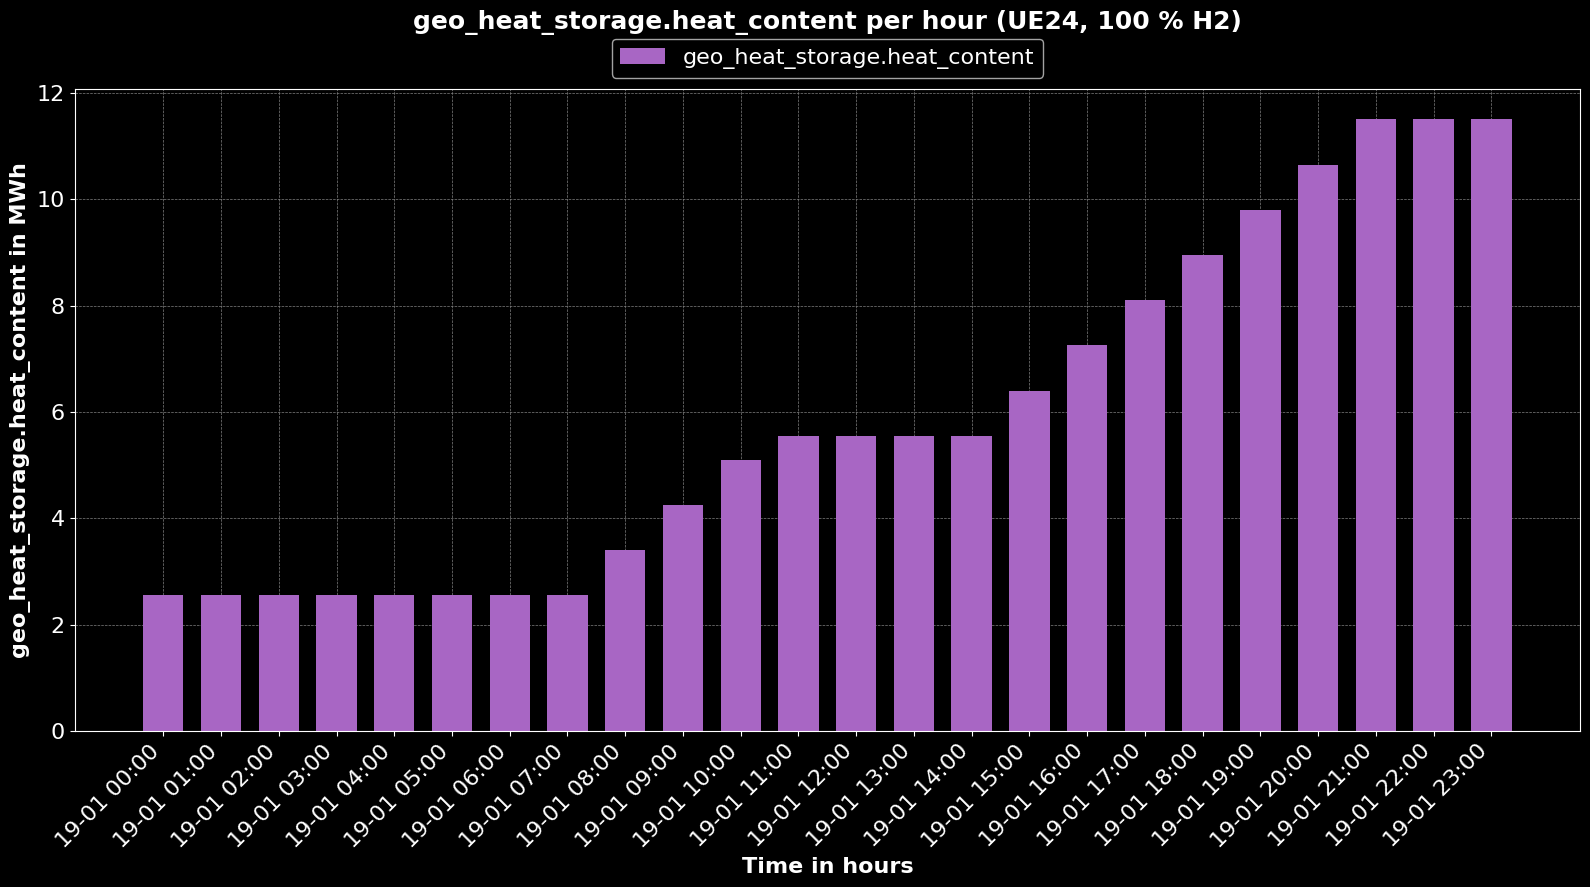

Diagram saved as: ../data/postprocessing/share_of_assets/2b_ue24_geo_0119.png
JSON file saved as: ../data/postprocessing/share_of_assets/assigned_colors.json


In [189]:
if __name__ == "__main__":
    # 1 load colors from json file: 
    colors_dict, color_file_json = load_color_data_from_json(
        colors_file=colors_filename,
        output_path=OUTPUT_PATH
        
        )
    
    # 2 Load data from csv after INPUT PATH: 
    # either for 2 scenarios:
    if compare_supplies_diagram == True:
        time_sums_df1 = calculate_sums_for_period(
        input_df=load_csv_results_in_df(
            input_path = INPUT_PATH_1
            ), 
        start_date = start_date, 
        end_date = end_date, 
        granularity=granularity, 
        time_column=time_column
        )
        time_sums_df2 = calculate_sums_for_period(
        input_df=load_csv_results_in_df
        (input_path = INPUT_PATH_2
         ), 
        start_date = start_date, 
        end_date = end_date, 
        granularity=granularity, 
        time_column=time_column
        )
        
        # 3a Plot with comparison of 2 scenarios (only function compare_plots)
        figure = decide_for_diagram_and_plot(
            storage_diagram = storage_diagram, 
            heat_demand_diagram = heat_demand_diagram,
            compare_supplies_diagram=compare_supplies_diagram,
            time_series_df1 = time_sums_df1,
            time_series_df2=time_sums_df2,
            all_assets = all_considered_assets,
            selected_assets = my_assets,
            type_of_energy = type_of_energy,
            granularity = granularity,
            actual_unit = actual_unit,
            target_unit = target_unit, 
            sharename = sharename, 
            fontsize = fontsize,
            title_size = title_size,
            key_to_label = key_to_label,
            colormap = colormap,
            assigned_colors_dict = colors_dict,
            type_of_heat_grid = type_of_heat_grid,
            heat_name=heat_name,
            assets_demand=assets_with_power_demand, 
            scenario_title=scenario_title
        )
    # or plot one scenario: 
    # compatible for all other functions with one csv input:
    else: 
        time_sums_df1 = calculate_sums_for_period(
            input_df=load_csv_results_in_df(
                input_path = INPUT_PATH_1
                ), 
            start_date = start_date, 
            end_date = end_date, 
            granularity=granularity, 
            time_column=time_column
            )
        
        # 3b plot diagram for one input
        figure = decide_for_diagram_and_plot(
            storage_diagram = storage_diagram, 
            heat_demand_diagram = heat_demand_diagram,
            compare_supplies_diagram=compare_supplies_diagram,
            time_series_df1 = time_sums_df1,
            all_assets = all_considered_assets,
            selected_assets = my_assets,
            type_of_energy = type_of_energy,
            granularity = granularity,
            actual_unit = actual_unit,
            target_unit = target_unit, 
            sharename = sharename, 
            fontsize = fontsize,
            title_size = title_size,
            key_to_label = key_to_label,
            colormap = colormap,
            assigned_colors_dict = colors_dict,
            type_of_heat_grid = type_of_heat_grid,
            heat_name=heat_name,
            assets_demand=assets_with_power_demand,
            scenario_title=scenario_title, 
            specific_value_diagram = specific_value_diagram,
            specific_value = specific_value_from_csv
        )

    # 4 save figure of plot in # 4.
    save_plot(
        fig=figure,
        output_path=OUTPUT_PATH,
        filename=filename 
    )

    # 5 save colors if new asset is added: 
    save_colors_for_key_json(
        colors_file=color_file_json, 
        assigned_colors=colors_dict
        )